In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### Keras
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.optimizers import Adam
from keras.regularizers import l2

## Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## Cargamos datos desde el archivo .FPT

In [154]:
contador = 0

with open('Data/output.fpt') as archivo:
    for linea in archivo:
        line_list = linea.strip().split()
        
        if ">" not in line_list:
            lista += line_list
            
            if len(lista) == 32:
                hexadecimal = ''.join(lista)
                binario = bin(int(hexadecimal, 16))[2:].zfill(1024)
                
                if contador == 0:
                    X = np.array(list(map(int, binario))).reshape(1024, 1).T
                    contador += 1
                
                else:
                    row = np.array(list(map(int, binario))).reshape(1024, 1).T
                    X = np.concatenate((X, row), axis=0)
                              
        else:
            lista = []

## Obtenemos valores de IC50 para las moléculas

In [155]:
df = pd.read_csv('Data/IC50_filtered_original.csv')

In [156]:
y = np.log10(np.array(df['ic50_value']).reshape(4126, 1))

## Separamos datos de entrenamiento y test

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Generamos red neuronal Feedforward

In [138]:
model = Sequential()

model.add(Dense(2600, input_dim=1024, activation='relu'))
model.add(Dense(1300, activation='relu'))
model.add(Dense(1300, activation='relu'))
model.add(Dense(650, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_224 (Dense)            (None, 2600)              2665000   
_________________________________________________________________
dense_225 (Dense)            (None, 1300)              3381300   
_________________________________________________________________
dense_226 (Dense)            (None, 1300)              1691300   
_________________________________________________________________
dense_227 (Dense)            (None, 650)               845650    
_________________________________________________________________
dense_228 (Dense)            (None, 300)               195300    
_________________________________________________________________
dense_229 (Dense)            (None, 150)               45150     
_________________________________________________________________
dense_230 (Dense)            (None, 70)              

In [139]:
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=["mean_absolute_percentage_error"])

checkpoint_name = 'Modelos/fp2_model_2.h5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data = (X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
164/165 [============================>.] - ETA: 0s - loss: 1.5918 - mean_absolute_percentage_error: 1266571.8750
Epoch 00001: val_loss improved from inf to 0.89808, saving model to Modelos/fp2_model_2.h5
165/165 [==============================] - 8s 46ms/step - loss: 1.5892 - mean_absolute_percentage_error: 1258895.8750 - val_loss: 0.8981 - val_mean_absolute_percentage_error: 48.6119
Epoch 2/100
164/165 [============================>.] - ETA: 0s - loss: 0.5515 - mean_absolute_percentage_error: 599000.2500
Epoch 00002: val_loss improved from 0.89808 to 0.62088, saving model to Modelos/fp2_model_2.h5
165/165 [==============================] - 7s 45ms/step - loss: 0.5509 - mean_absolute_percentage_error: 595370.0625 - val_loss: 0.6209 - val_mean_absolute_percentage_error: 43.5357
Epoch 3/100
165/165 [==============================] - ETA: 0s - loss: 0.4234 - mean_absolute_percentage_error: 594168.6875
Epoch 00003: val_loss did not improve from 0.62088
165/165 [================

In [140]:
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train))) 
pred_test= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test))) 

0.18322964821559426
0.6532278924723277


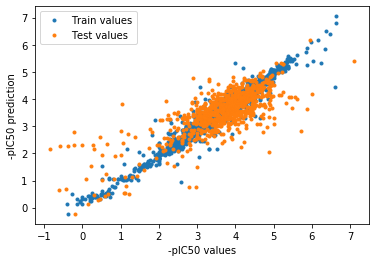

In [141]:
plt.figure(3)
plt.clf()
plt.xlabel('-pIC50 values')
plt.ylabel('-pIC50 prediction')
plt.plot(y_train, pred_train ,'.', label = 'Train values')
plt.plot(y_test, pred_test, '.', label = 'Test values')
plt.legend()
plt.savefig('Images/FP2.png')
plt.show()

In [142]:
r2_score(y_test, pred_test)

0.567510815025801

In [143]:
modelo = Sequential()

modelo.add(Dense(2600, input_dim=1024, activation='relu'))
modelo.add(Dense(1300, activation='relu'))
modelo.add(Dense(1300, activation='relu'))
modelo.add(Dense(650, activation='relu'))
modelo.add(Dense(300, activation='relu'))
modelo.add(Dense(150, activation='relu'))
modelo.add(Dense(70, activation='relu'))
modelo.add(Dense(35, activation='relu'))
modelo.add(Dense(15, activation='relu'))
modelo.add(Dense(5, activation='relu'))
modelo.add(Dense(1, activation='linear'))

modelo.load_weights("Modelos/fp2_model_2.h5")

In [144]:
pred_train= modelo.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train))) 
pred_test= modelo.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test))) 

0.2097216415619616
0.6135515076174972


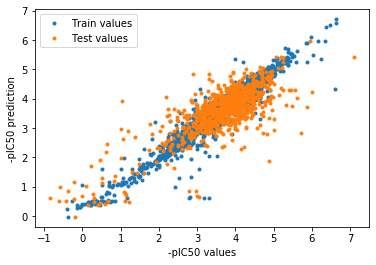

In [145]:
plt.figure(3)
plt.clf()
plt.xlabel('-pIC50 values')
plt.ylabel('-pIC50 prediction')
plt.plot(y_train, pred_train ,'.', label = 'Train values')
plt.plot(y_test, pred_test, '.', label = 'Test values')
plt.legend()
plt.savefig('Images/FP2.png')
plt.show()

In [146]:
r2_score(y_test, pred_test)

0.6184531558583777